## 自動編碼器用於 mnist 降噪

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 16)                5019

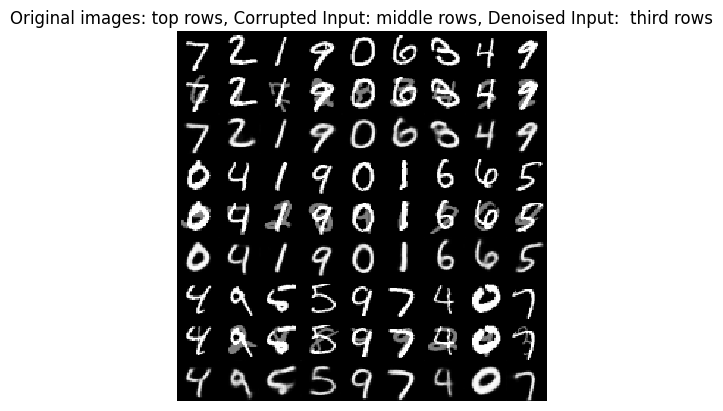

Epoch 1/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0128 - val_loss: 0.0108
Epoch 2/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 3/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0118 - val_loss: 0.0100
Epoch 4/10
1875/1875 [==============================] - 219s 117ms/step - loss: 0.0115 - val_loss: 0.0099
Epoch 5/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0113 - val_loss: 0.0099
Epoch 6/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0112 - val_loss: 0.0097
Epoch 7/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0110 - val_loss: 0.0095
Epoch 8/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0109 - val_loss: 0.0094
Epoch 9/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0108 - val_loss: 0.0092
Epoch 10/10
1875/1875 [==============================] - 30s 1

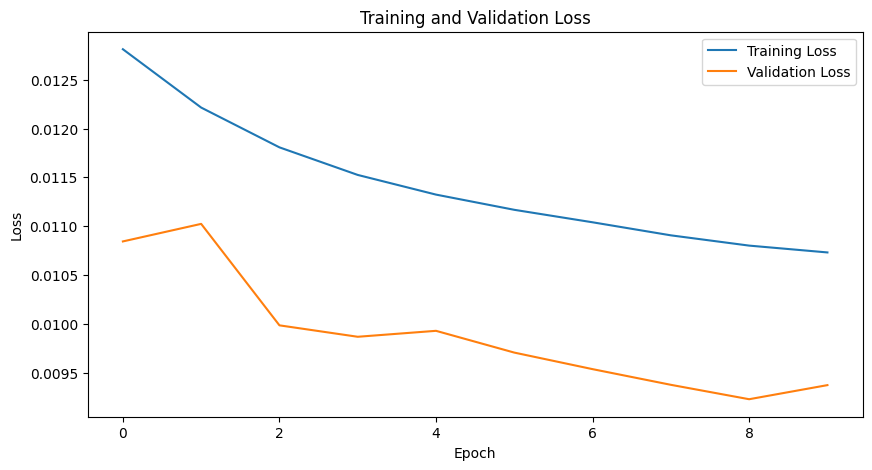

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.layers import Dropout
np.random.seed(1337)

# load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.5
#noise = np.random.normal(loc=0.85, scale=0.85, size=x_train.shape)
#x_train_noisy = x_train + noise
#noise = np.random.normal(loc=0.85, scale=0.85, size=x_test.shape)
#x_test_noisy = x_test + noise

# adding noise may exceed normalized pixel values>1.0 or <0.0
# clip pixel values >1.0 to 1.0 and <0.0 to 0.0
#x_train_noisy = np.clip(x_train_noisy, 0., 1.)
#x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# 假设 x_train 是原始的 MNIST 训练集图像

# 選擇作為浮水印的圖像
random_indices = np.random.choice(x_train.shape[0], size=x_train.shape[0], replace=True)
noise_images = x_train[random_indices]

# 将noise對比為 50%
# 首先noise到 0 和 1 之间，乘 0.5對比
noise_images = noise_images * 0.5

# 帶浮水印的訓練圖像
x_train_noisy = x_train + noise_images
x_train_noisy = np.clip(x_train_noisy, 0., 1.)  # 保證圖像在0到1

# 生成測試集
random_indices_test = np.random.choice(x_test.shape[0], size=x_test.shape[0], replace=True)
noise_images_test = x_test[random_indices_test]
noise_images_test = noise_images_test * 0.5
x_test_noisy = x_test + noise_images_test
x_test_noisy = np.clip(x_test_noisy, 0., 1.)  # 保證圖像在0到1
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer 原來是
layer_filters = [32, 64]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
    x = Dropout(0.25)(x)  # 加個丟棄率為25的 Dropout
# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which can be processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
x = Dropout(0.25)(latent)  # 在 Dense 一樣要有 Dropout
# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

# reconstruct the denoised input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

# train the autoencoder
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=2,
                batch_size=batch_size)

# predict the autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

# 3 sets of images with 9 MNIST digits
# 1st rows - original images
# 2nd rows - images corrupted by noise
# 3rd rows - denoised images
rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()
history = autoencoder.fit(
    x_train_noisy,
    x_train,
    validation_data=(x_test_noisy, x_test),
# 改一下 epoch    
    epochs=10,
    batch_size=batch_size
)

# plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()